<font color='red'>Warning:</font> The **"Validate"** button does **not work** properly for this assignment; please **avoid** using it.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
if os.path.exists('./glmnet/GLMnet.so'):
    os.remove('./glmnet/GLMnet.so')
os.system('gfortran ./glmnet/GLMnet.f -fPIC -fdefault-real-8 -shared -o ./glmnet/GLMnet.so')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from glmnet import glmnet; from glmnetPlot import glmnetPlot 
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

from utils import test_case_checker, perform_computation

warnings.filterwarnings('ignore')

# Assignment Summary

1. **Linear regression with various regularizers** The UCI Machine Learning dataset repository hosts a dataset giving features of music, and the location (latitude and longitude) at which that music originate. There are actually two versions of this dataset. Either one is OK, but I think you'll find the one with more independent variables more interesting. In this assignment you will investigate methods to predict music location from the provided features. You should regard latitude and longitude as entirely independent.
  * First, build a straightforward linear regression of location (latitude and longitude) against features. What is the R-squared? Plot a graph evaluating each regression.
  * Does a Box-Cox transformation improve the regressions? Notice that the dependent variable has some negative values, which Box-Cox doesn't like. You can deal with this by remembering that these are angles, so you get to choose the origin. For the rest of the exercise, use the transformation if it does improve things, otherwise, use the raw data.
  * Use glmnet to produce:
    * A regression regularized by L2 (a ridge regression). You should estimate the regularization coefficient that produces the minimum error. Is the regularized regression better than the unregularized regression?
    * A regression regularized by L1 (a lasso regression). You should estimate the regularization coefficient that produces the minimum error. How many variables are used by this regression? Is the regularized regression better than the unregularized regression?
    * A regression regularized by elastic net (equivalently, a regression regularized by a convex combination of L1 and L2 weighted by a parameter `alpha`). Try three values of `alpha`. You should estimate the regularization coefficient `lambda` that produces the minimum error. How many variables are used by this regression? Is the regularized regression better than the unregularized regression?
2. **Logistic regression** The UCI Machine Learning dataset repository hosts a dataset giving whether a Taiwanese credit card user defaults against a variety of features here. In this part of the assignment you will use logistic regression to predict whether the user defaults. You should ignore outliers, but you should try the various regularization schemes discussed above.

<font color='red'>Attention:</font> After finishing this notebook, you will need to do a follow-up quiz as well. The overall grade for this assignment is based on this notebook and the follow-up quiz.

# 1. Problem 1

## 1.0 Data

### Description

The UCI Machine Learning dataset repository hosts a dataset that provides a set of features of music, and the location (latitude and longitude) at which that music originates at https://archive.ics.uci.edu/ml/datasets/Geographical+Original+of+Music. 

### Information Summary

* **Input/Output**: This data has 118 columns; the first 116 columns are the music features, and the last two columns are the music origin's latitude and the longitude, respectively.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to **properly** fit a linear regression model.

In [2]:
df = pd.read_csv('music/default_plus_chromatic_features_1059_tracks.txt', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-0.364194,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,0.936616,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,0.603755,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,0.187169,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,1.620715,34.03,-6.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,0.399577,0.310805,-0.039326,-0.111546,0.304586,-0.943453,0.114960,-0.335898,0.826753,-0.393786,...,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-0.415247,-6.17,35.74
1055,1.640386,1.306224,0.192745,-1.816855,-1.311906,-2.128963,-1.875967,0.094232,-1.429742,0.873777,...,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,-0.817538,11.55,104.91
1056,-0.772360,-0.670596,-0.840420,-0.832105,0.277346,1.152162,0.241470,0.229092,0.019036,-0.068804,...,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,-0.515309,41.33,19.80
1057,-0.996965,-1.099395,3.515274,-0.508185,-1.102654,0.192081,0.069821,0.264674,-0.411533,0.501164,...,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,0.074855,54.68,25.31


In [3]:
X_full = df.iloc[:,:-2].values
lat_full = df.iloc[:,-2].values
lon_full = df.iloc[:,-1].values
X_full.shape, lat_full.shape, lon_full.shape

((1059, 116), (1059,), (1059,))

### Making the Dependent Variables Positive

This will make the data compatible with the box-cox transformation that we will later use.

In [4]:
lat_full = 90 + lat_full
lon_full = 180 + lon_full

## 1.1 Outlier Detection

In [5]:
outlier_detector = 'LOF'

if outlier_detector == 'LOF':
    outlier_clf = LocalOutlierFactor(novelty=False)
elif outlier_detector == 'IF':
    outlier_clf = IsolationForest(warm_start=True, random_state=12345)
elif outlier_detector == 'EE':
    outlier_clf = EllipticEnvelope(random_state=12345)
else:
    outlier_clf = None

is_not_outlier = outlier_clf.fit_predict(X_full) if outlier_clf is not None else np.ones_like(lat_full)>0
X_useful = X_full[is_not_outlier==1,:]
lat_useful = lat_full[is_not_outlier==1]
lon_useful = lon_full[is_not_outlier==1]

**Suggestion**: You may find it instructive to explore the effect of the different outlier detection methods on the accuracy of the linear regression model. 

There is a brief introduction about each of the implemented OD methods along with some nice visualizations at https://scikit-learn.org/stable/modules/outlier_detection.html .

## 1.2 Train-Validation-Test Split

In [6]:
train_val_indices, test_indices = train_test_split(np.arange(X_useful.shape[0]), test_size=0.2, random_state=12345)

X_train_val = X_useful[train_val_indices, :]
lat_train_val = lat_useful[train_val_indices]
lon_train_val = lon_useful[train_val_indices]

X_test = X_useful[test_indices, :]
lat_test = lat_useful[test_indices]
lon_test = lon_useful[test_indices]

## 1.3 Building a Simple Linear Regression Model (Scikit-Learn)

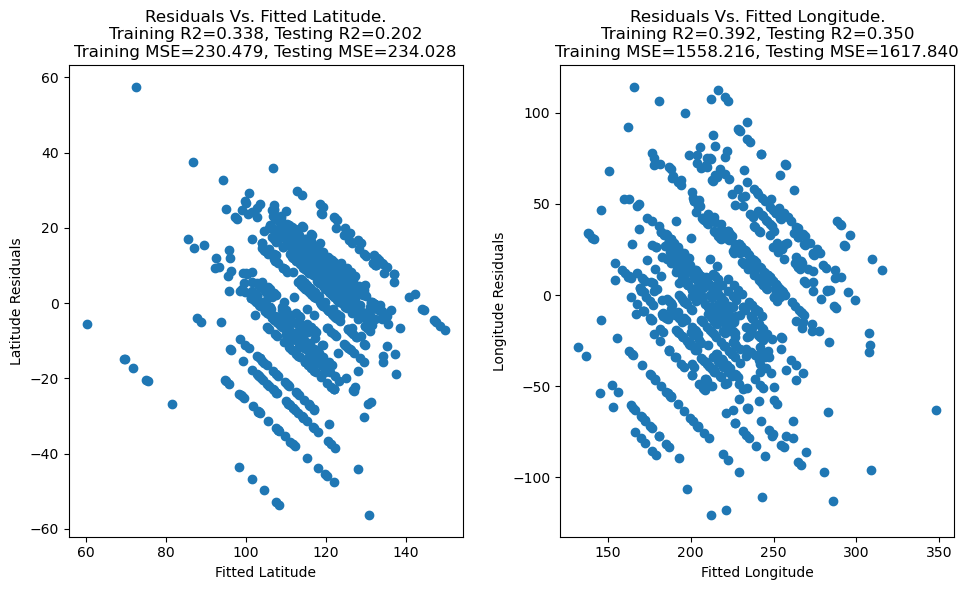

In [7]:
from sklearn.linear_model import LinearRegression

if perform_computation:
    X, Y = X_train_val, lat_train_val
    reg_lat = LinearRegression().fit(X, Y)
    train_r2_lat = reg_lat.score(X,Y)
    fitted_lat = reg_lat.predict(X)
    residuals_lat = Y-fitted_lat
    train_mse_lat = (residuals_lat**2).mean()
    test_mse_lat = np.mean((reg_lat.predict(X_test)-lat_test)**2)
    test_r2_lat = reg_lat.score(X_test,lat_test)

    X, Y = X_train_val, lon_train_val
    reg_lon = LinearRegression().fit(X, Y)
    train_r2_lon = reg_lon.score(X,Y)
    fitted_lon = reg_lon.predict(X)
    residuals_lon = Y-fitted_lon
    train_mse_lon = (residuals_lon**2).mean()
    test_mse_lon = np.mean((reg_lon.predict(X_test)-lon_test)**2)
    test_r2_lon = reg_lon.score(X_test,lon_test)

    fig, axes = plt.subplots(1,2, figsize=(10,6.), dpi=100)

    ax = axes[0]
    ax.scatter(fitted_lat, residuals_lat)
    ax.set_xlabel('Fitted Latitude')
    ax.set_ylabel('Latitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Latitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lat, test_r2_lat) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lat, test_mse_lat))

    ax = axes[1]
    ax.scatter(fitted_lon, residuals_lon)
    ax.set_xlabel('Fitted Longitude')
    ax.set_ylabel('Longitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Longitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lon, test_r2_lon) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lon, test_mse_lon))
    fig.set_tight_layout([0, 0, 1, 1])

## 1.4 Building a Simple Linear Regression (glmnet)

# <span style="color:blue">Task 1</span>

Write a function `glmnet_vanilla` that fits a linear regression model from the glmnet library, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_Y`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

**Important Notes**:
1. **Do not** play with the default options unless you're instructed to.
2. You may find this glmnet documentation helpful: https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb
    * You may find it useful to read about the gaussian family in the first section, the functions `glmnet` and `glmnetPredict`, and their arguments.
3. **Do not** perform any cross-validation for this task.
4. **Do not** play with the regularization settings in the **training call**.
5. **For prediction** on the test data, make sure that a **regularization coefficient of 0** was used. 
6. You may need to choose the proper `family` variable when you're training the model.
7. You may need to choose the proper `ptype` variable when you're predicting on the test data.

In [8]:
def glmnet_vanilla(X_train, Y_train, X_test=None):
    if X_test is None:
        X_test = X_train.copy().astype(np.float64)
    # Creating Scratch Variables For glmnet Consumption
    X_train = X_train.copy().astype(np.float64)
    Y_train = Y_train.copy().astype(np.float64)
    
    # your code here
    glmnet_model = glmnet(x = X_train, y = Y_train, family = 'gaussian')
    fitted_Y = glmnetPredict(glmnet_model, X_test, s = scipy.float64([0.00])).reshape(-1)
    
    
    assert fitted_Y.shape == (X_test.shape[0],), 'fitted_Y should not be two dimensional (hint: reshaping may be helpful)'
    assert isinstance(glmnet_model, dict)
    assert list(glmnet_model.keys()) == ['a0','beta','dev','nulldev','df','lambdau','npasses','jerr','dim','offset','class']
    return fitted_Y, glmnet_model

In [9]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_pred, some_model = glmnet_vanilla(some_X, some_Y)
assert np.array_equal(some_pred.round(3), np.array([20.352, 44.312, 39.637, 74.146, 20.352, 49.605, 24.596]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_vanilla(*args,**kwargs)[0], task_id=1)
assert test_results['passed'], test_results['message']

In [10]:
def train_and_plot(trainer):
    # Latitude Training, Prediction, Evaluation, etc.
    lat_pred_train = trainer(X_train_val, lat_train_val, X_train_val)[0]
    train_r2_lat = r2_score(lat_train_val, lat_pred_train)
    residuals_lat = lat_train_val - lat_pred_train
    train_mse_lat = (residuals_lat**2).mean()
    lat_pred_test = trainer(X_train_val, lat_train_val, X_test)[0]
    test_mse_lat = np.mean((lat_pred_test-lat_test)**2)
    test_r2_lat = r2_score(lat_test, lat_pred_test)

    # Longitude Training, Prediction, Evaluation, etc.
    lon_pred_train = trainer(X_train_val, lon_train_val, X_train_val)[0]
    train_r2_lon = r2_score(lon_train_val, lon_pred_train)
    residuals_lon = lon_train_val - lon_pred_train
    train_mse_lon = (residuals_lon**2).mean()
    lon_pred_test = trainer(X_train_val, lon_train_val, X_test)[0]
    test_mse_lon = np.mean((lon_pred_test-lon_test)**2)
    test_r2_lon = r2_score(lon_test, lon_pred_test)

    fig, axes = plt.subplots(1,2, figsize=(10,6.), dpi=100)

    ax = axes[0]
    ax.scatter(lat_pred_train, residuals_lat)
    ax.set_xlabel('Fitted Latitude')
    ax.set_ylabel('Latitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Latitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lat, test_r2_lat) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lat, test_mse_lat))

    ax = axes[1]
    ax.scatter(lon_pred_train, residuals_lon)
    ax.set_xlabel('Fitted Longitude')
    ax.set_ylabel('Longitude Residuals')
    _ = ax.set_title(f'Residuals Vs. Fitted Longitude.\n' +
                     f'Training R2=%.3f, Testing R2=%.3f\n' % (train_r2_lon, test_r2_lon) +
                     f'Training MSE=%.3f, Testing MSE=%.3f' % (train_mse_lon, test_mse_lon))
    fig.set_tight_layout([0, 0, 1, 1])
    

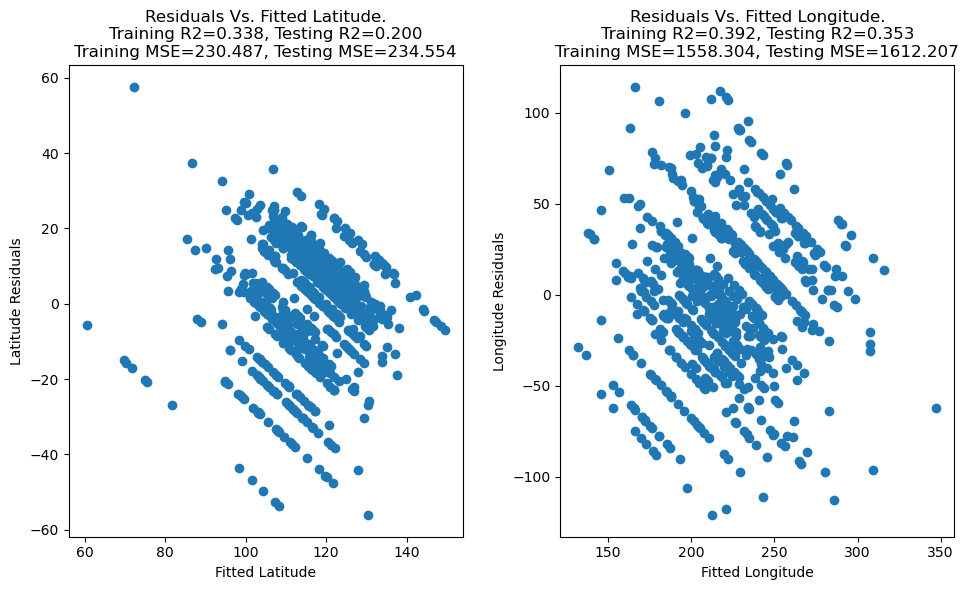

In [11]:
if perform_computation:
    train_and_plot(glmnet_vanilla)

## 1.5 Box-Cox Transformation

# <span style="color:blue">Task 2</span>

Write a function `boxcox_lambda` that takes a numpy array `y` as input, and produce the best box-cox transformation $\lambda$ parameter `best_lam` as a scalar. 

**Hint**: Do not implement this function yourself. You may find some useful function here https://docs.scipy.org/doc/scipy/reference/stats.html.

In [12]:
def boxcox_lambda(y):
    assert y.ndim==1
    assert (y>0).all()
    
    # your code here
    best_lam = scipy.stats.boxcox_normmax(y, method='mle')
    
    return best_lam

In [13]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
assert boxcox_lambda(some_Y).round(3) == -0.216

# Checking against the pre-computed test database
test_results = test_case_checker(boxcox_lambda, task_id=2)
assert test_results['passed'], test_results['message']

# <span style="color:blue">Task 3</span>

Write a function `boxcox_transform` that takes a numpy array `y` and the box-cox transformation $\lambda$ parameter `lam` as input, and returns the numpy array `transformed_y` which is the box-cox transformation of `y` using $\lambda$. 

**Hint**: Do not implement this function yourself. You may find some useful function here https://docs.scipy.org/doc/scipy/reference/stats.html.

In [14]:
def boxcox_transform(y, lam):
    assert y.ndim==1
    assert (y>0).all()
    
    # your code here
    transformed_y = scipy.stats.boxcox(y, lam)
    
    return transformed_y

In [15]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
assert np.array_equal(boxcox_transform(some_Y, lam=0).round(3), np.array([2.996, 3.807, 3.689, 4.317, 2.996, 3.892, 3.178]))

# Checking against the pre-computed test database
test_results = test_case_checker(boxcox_transform, task_id=3)
assert test_results['passed'], test_results['message']

# <span style="color:blue">Task 4</span>

Write a function `boxcox_inv_transform` that takes a numpy array `transformed_y` and the box-cox transformation $\lambda$ parameter `lam` as input, and returns the numpy array `y` which is the inverse box-cox transformation of `transformed_y` using $\lambda$. 

1. If $\lambda \neq 0$: 
$$y = |y^{bc}\cdot \lambda + 1|^{\frac{1}{\lambda}}$$
2. If $\lambda = 0$:
$$y = e^{y^{bc}}$$

**Hint**: You need to implement this function yourself!

**Important Note**: Be very careful about the signs, absolute values, and raising to exponents with decimal points. For something to be raised to any power that is not a full integer, you need to make sure that the base is positive.

In [16]:
def boxcox_inv_transform(transformed_y, lam):
    
    # your code here
    if lam != 0:
        y = np.abs(transformed_y * lam + 1) ** (1 / lam)
    else:
        y = np.exp(transformed_y)
    
    assert not np.isnan(y).any()
    return y

In [17]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)/10
some_invbc = boxcox_inv_transform(some_Y, lam=0).round(3)
assert np.array_equal(some_invbc, np.array([7.389, 90.017, 54.598, 1808.042, 7.389,  134.29 ,11.023]))

another_invbc = boxcox_inv_transform(some_Y, lam=5).round(3)
assert np.array_equal(another_invbc, np.array([1.615, 1.88 , 1.838, 2.075, 1.615, 1.911, 1.67 ]))

iden = boxcox_inv_transform(boxcox_transform(some_Y, lam=5), lam=5).round(3)
assert np.array_equal(iden, some_Y.round(3))

# Checking against the pre-computed test database
test_results = test_case_checker(boxcox_inv_transform, task_id=4)
assert test_results['passed'], test_results['message']

# <span style="color:blue">Task 5</span>

Using the box-cox functions you previously wrote, write a function `glmnet_bc` that fits a linear regression model from the glmnet library with the box-cox transformation applied on the labels, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_test`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

You should first obtain the best box-cox lambda parameter from the training data. Then transform the training labels before passing them to the training procedure. This will cause the trained model to be operating on the box-cox transformed space. Therefore, the test predictions should be box-cox inverse transformed before reporting them as output. 

Use the `glmnet_vanilla` function you already written on the box-cox transformed data.

In [18]:
def glmnet_bc(X_train, Y_train, X_test=None):
    
    # your code here
    lam = boxcox_lambda(Y_train)
    y_bc = boxcox_transform(Y_train, lam)
    fitted_test, glmnet_model = glmnet_vanilla(X_train, y_bc, X_test)
    fitted_test = boxcox_inv_transform(fitted_test, lam)
    
    assert isinstance(glmnet_model, dict)
    return fitted_test, glmnet_model

In [19]:
some_X = (np.arange(35).reshape(7,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_pred, some_model = glmnet_bc(some_X, some_Y)
assert np.array_equal(some_pred.round(3), np.array([20.012, 42.985, 40.189, 75.252, 20.012, 50.095, 24.32 ]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_bc(*args,**kwargs)[0], task_id=5)
assert test_results['passed'], test_results['message']

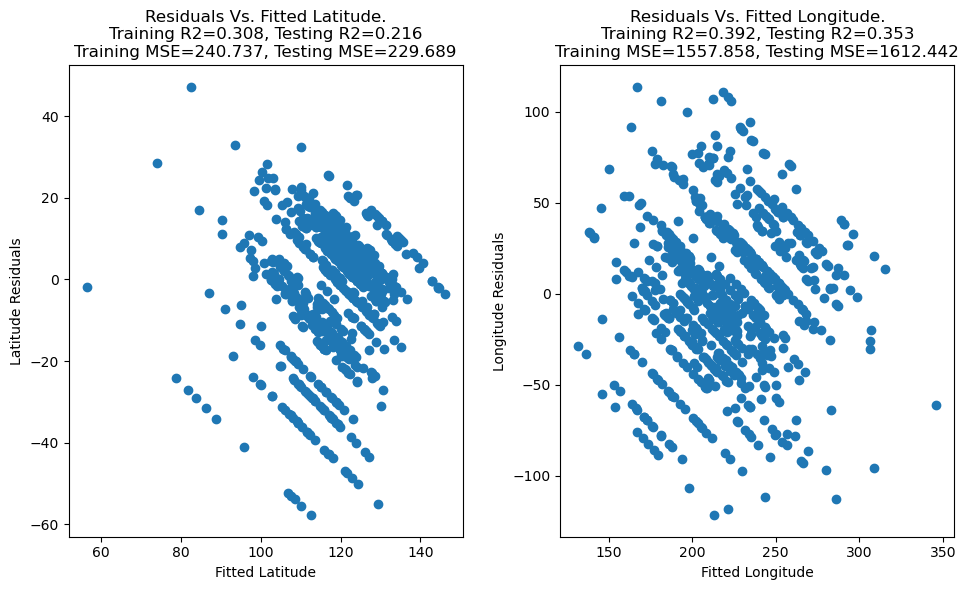

In [20]:
if perform_computation:
    train_and_plot(glmnet_bc)

## 1.6 Ridge Regression

# <span style="color:blue">Task 6</span>

Write a function `glmnet_ridge` that fits a Ridge-regression model from the glmnet library, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_Y_test`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

**Important Notes**:
1. **Do not** play with the default options unless you're instructed to.
2. You may find this glmnet documentation helpful: https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb
  * You may find it useful to read about the gaussian family in the first section, cross-validation, the functions `cvglmnet` and `cvglmnetPredict`, and their arguments.
3. You **should** perform **cross-validation** for this task.
4. Use **10-folds** for cross-validation.
5. Ask glmnet to search over **100** different values of the regularization coefficient.
6. Use the **Mean Squared Error** as a metric for cross-validation.
7. For **prediction**, use the **regularization coefficient** that produces the **minimum cross-validation MSE**.
7. You may need to choose the proper `family` variable when you're training the model.
8. You may need to choose the proper `ptype` variable when you're predicting on the test data.

In [21]:
def glmnet_ridge(X_train, Y_train, X_test=None):
    
    if X_test is None:
        X_test = X_train.copy().astype(np.float64)
    # Creating Scratch Variables For glmnet Consumption
    X_train = X_train.copy().astype(np.float64)
    Y_train = Y_train.copy().astype(np.float64)
    
    # your code here
    glmnet_model = cvglmnet(x = X_train, y = Y_train, alpha = 0)
    fitted_Y_test = cvglmnetPredict(glmnet_model, X_test, s = 'lambda_min').reshape(-1)
    
    assert fitted_Y_test.shape == (X_test.shape[0],), 'fitted_Y should not be two dimensional (hint: reshaping may be helpful)'
    assert isinstance(glmnet_model, dict)
    return fitted_Y_test, glmnet_model

In [22]:
some_X = (np.arange(350).reshape(70,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_pred, some_model = glmnet_ridge(some_X, some_Y)
assert np.array_equal(some_pred.round(3)[:5], np.array([21.206, 45.052, 40.206, 73.639, 21.206]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_ridge(*args,**kwargs)[0], task_id=6)
assert test_results['passed'], test_results['message']

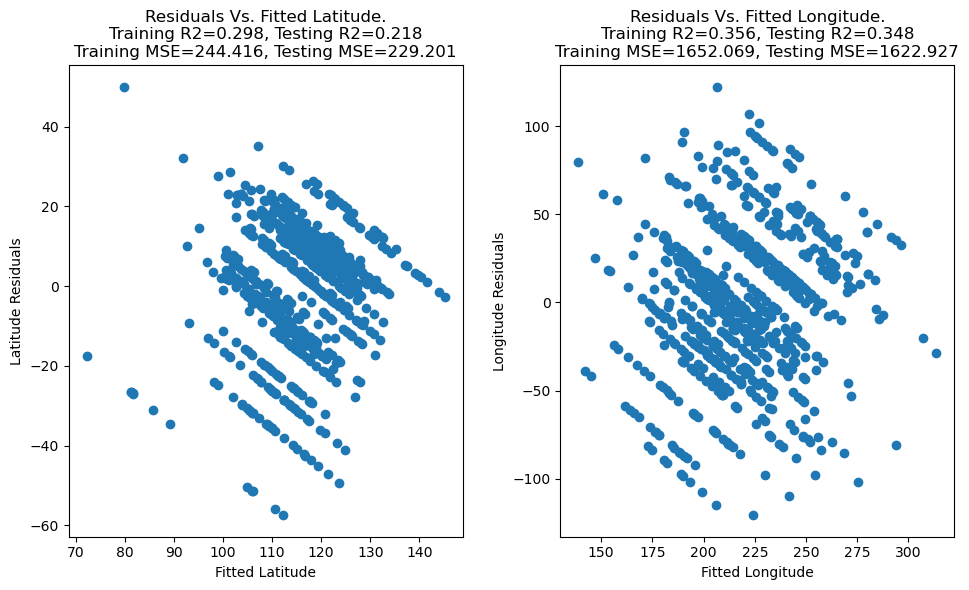

In [23]:
if perform_computation:
    train_and_plot(glmnet_ridge)

## 1.7 Lasso Regression

# <span style="color:blue">Task 7</span>

Write a function `glmnet_lasso` that fits a Lasso-regression model from the glmnet library, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_Y_test`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

**Important Notes**:
1. **Do not** play with the default options unless you're instructed to.
2. You may find this glmnet documentation helpful: https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb
  * You may find it useful to read about the gaussian family in the first section, cross-validation, the functions `cvglmnet` and `cvglmnetPredict`, and their arguments (specially the alpha parameter for `cvglmnet`).
3. You **should** perform **cross-validation** for this task.
4. Use **10-folds** for cross-validation.
5. Ask glmnet to search over **100** different values of the regularization coefficient.
6. Use the **Mean Squared Error** as a metric for cross-validation.
7. For **prediction**, use the **regularization coefficient** that produces the **minimum cross-validation MSE**.
7. You may need to choose the proper `family` variable when you're training the model.
8. You may need to choose the proper `ptype` variable when you're predicting on the test data.

In [24]:
def glmnet_lasso(X_train, Y_train, X_test=None):
    
    if X_test is None:
        X_test = X_train.copy().astype(np.float64)
    # Creating Scratch Variables For glmnet Consumption
    X_train = X_train.copy().astype(np.float64)
    Y_train = Y_train.copy().astype(np.float64)
    
    # your code here
    glmnet_model = cvglmnet(x = X_train, y = Y_train, alpha = 1)
    fitted_Y_test = cvglmnetPredict(glmnet_model, X_test, s = 'lambda_min').reshape(-1)
    
    assert fitted_Y_test.shape == (X_test.shape[0],), 'fitted_Y should not be two dimensional (hint: reshaping may be helpful)'
    assert isinstance(glmnet_model, dict)
    return fitted_Y_test, glmnet_model

In [25]:
some_X = (np.arange(350).reshape(70,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_pred, some_model = glmnet_lasso(some_X, some_Y)
assert np.array_equal(some_pred.round(3)[:5], np.array([20.716, 45.019, 40.11 , 74.153, 20.716]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_lasso(*args,**kwargs)[0], task_id=7)
assert test_results['passed'], test_results['message']

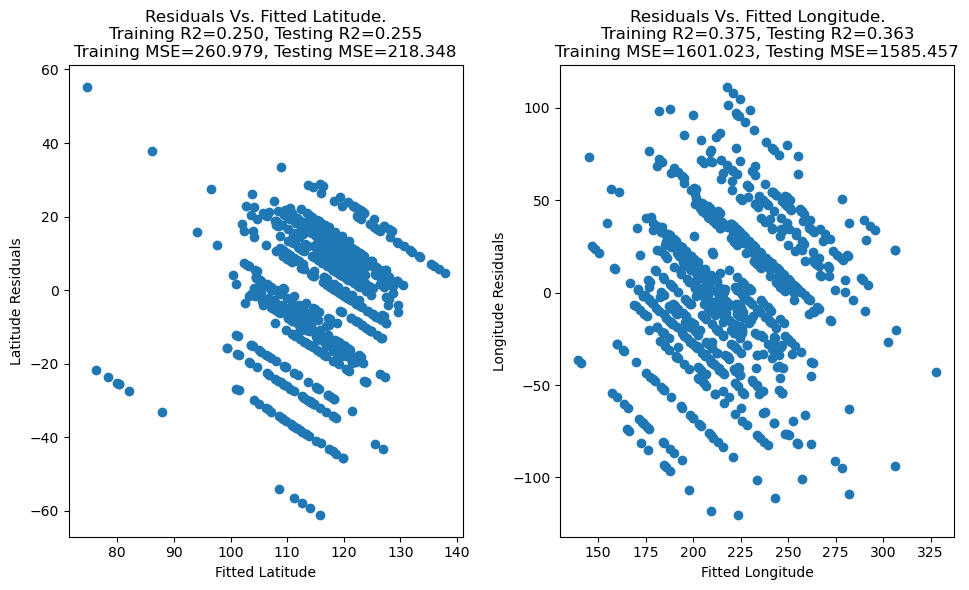

In [26]:
if perform_computation:
    train_and_plot(glmnet_lasso)

### Analysis

In [27]:
if perform_computation:
    _, lasso_model = glmnet_lasso(X_train_val, lat_train_val, X_train_val)
    _, ridge_model = glmnet_ridge(X_train_val, lat_train_val, X_train_val)

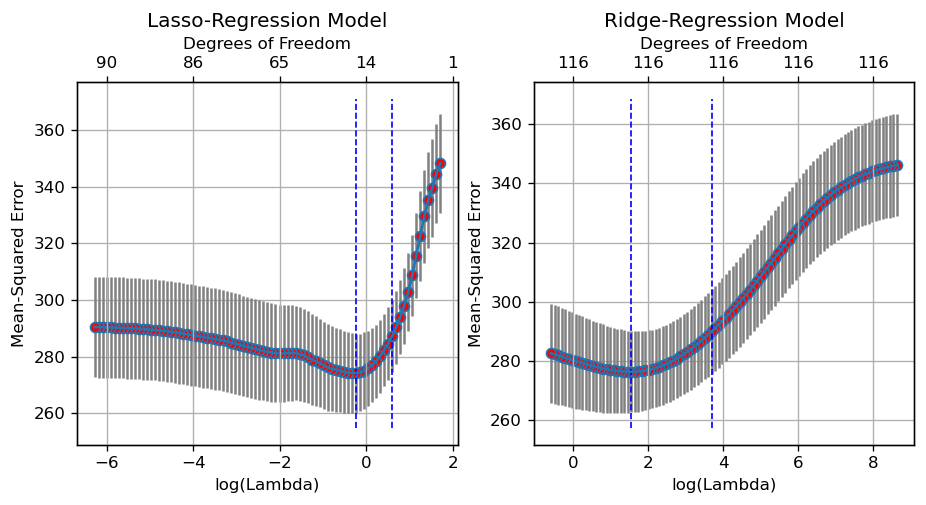

In [28]:
if perform_computation:
    f = plt.figure(figsize=(9,4), dpi=120)
    f.add_subplot(1,2,1)
    cvglmnetPlot(lasso_model)
    plt.gca().set_title('Lasso-Regression Model')
    f.add_subplot(1,2,2)
    cvglmnetPlot(ridge_model)
    _ = plt.gca().set_title('Ridge-Regression Model')

In [29]:
if perform_computation:
    lasso_nz_coefs = np.sum(cvglmnetCoef(lasso_model, s = 'lambda_min') != 0)
    ridge_nz_coefs = np.sum(cvglmnetCoef(ridge_model, s = 'lambda_min') != 0)
    print(f'A Total of {lasso_nz_coefs} Lasso-Regression coefficients were non-zero.')
    print(f'A Total of {ridge_nz_coefs} Ridge-Regression coefficients were non-zero.')

A Total of 17 Lasso-Regression coefficients were non-zero.
A Total of 117 Ridge-Regression coefficients were non-zero.


## 1.8 Elastic-net Regression

# <span style="color:blue">Task 8</span>

Write a function `glmnet_elastic` that fits an elastic-net model from the glmnet library, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.
4. `alpha`: The elastic-net regularization parameter $\alpha$.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_Y_test`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

**Important Notes**:
1. **Do not** play with the default options unless you're instructed to.
2. You may find this glmnet documentation helpful: https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb
  * You may find it useful to read about the gaussian family in the first section, cross-validation, the functions `cvglmnet` and `cvglmnetPredict`, and their arguments (specially the alpha parameter for `cvglmnet`).
3. You **should** perform **cross-validation** for this task.
4. Use **10-folds** for cross-validation.
5. Ask glmnet to search over **100** different values of the regularization coefficient.
6. Use the **Mean Squared Error** as a metric for cross-validation.
7. For **prediction**, use the **regularization coefficient** that produces the **minimum cross-validation MSE**.
7. You may need to choose the proper `family` variable when you're training the model.
8. You may need to choose the proper `ptype` variable when you're predicting on the test data.

In [30]:
def glmnet_elastic(X_train, Y_train, X_test=None, alpha=1):
    
    if X_test is None:
        X_test = X_train.copy().astype(np.float64)
    # Creating Scratch Variables For glmnet consumption
    X_train = X_train.copy().astype(np.float64)
    Y_train = Y_train.copy().astype(np.float64)
    
    # your code here
    glmnet_model = cvglmnet(x = X_train, y = Y_train, alpha=alpha)#lambda_min
    fitted_Y_test = cvglmnetPredict(glmnet_model, X_test, s = 'lambda_min').reshape(-1)
    
    assert fitted_Y_test.shape == (X_test.shape[0],), 'fitted_Y should not be two dimensional (hint: reshaping may be helpful)'
    assert isinstance(glmnet_model, dict)
    return fitted_Y_test, glmnet_model

In [31]:
some_X = (np.arange(350).reshape(70,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)
some_pred, some_model = glmnet_elastic(some_X, some_Y, alpha=0.3)
assert np.array_equal(some_pred.round(3)[:5], np.array([20.77 , 45.028, 40.125, 74.112, 20.77 ]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_elastic(*args,**kwargs)[0], task_id=8)
assert test_results['passed'], test_results['message']

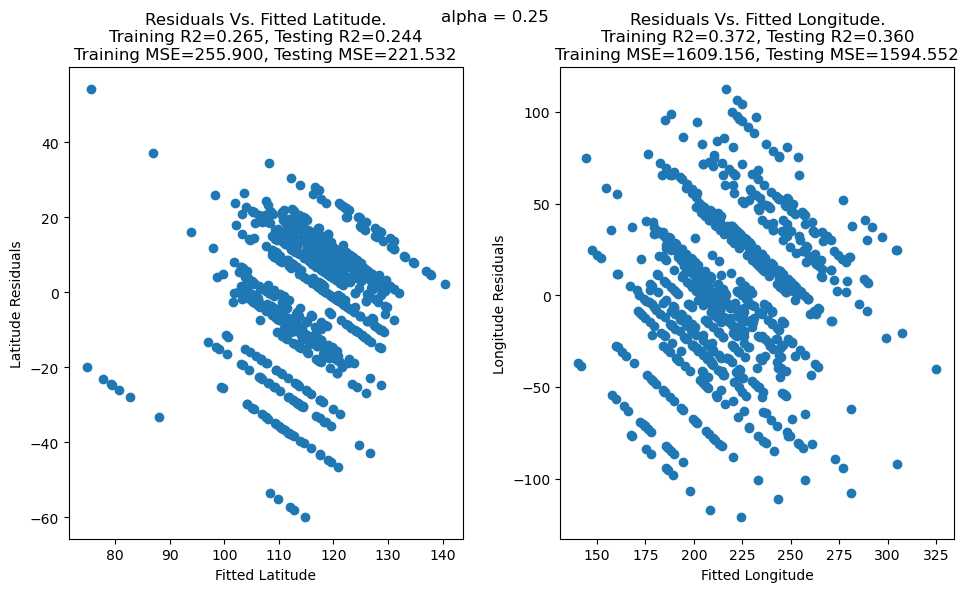

In [32]:
if perform_computation:
    alpha = 0.25
    train_and_plot(lambda *args, **kwargs: glmnet_elastic(*args, **kwargs, alpha=alpha))
    _ = plt.gcf().suptitle(f'alpha = {alpha}')

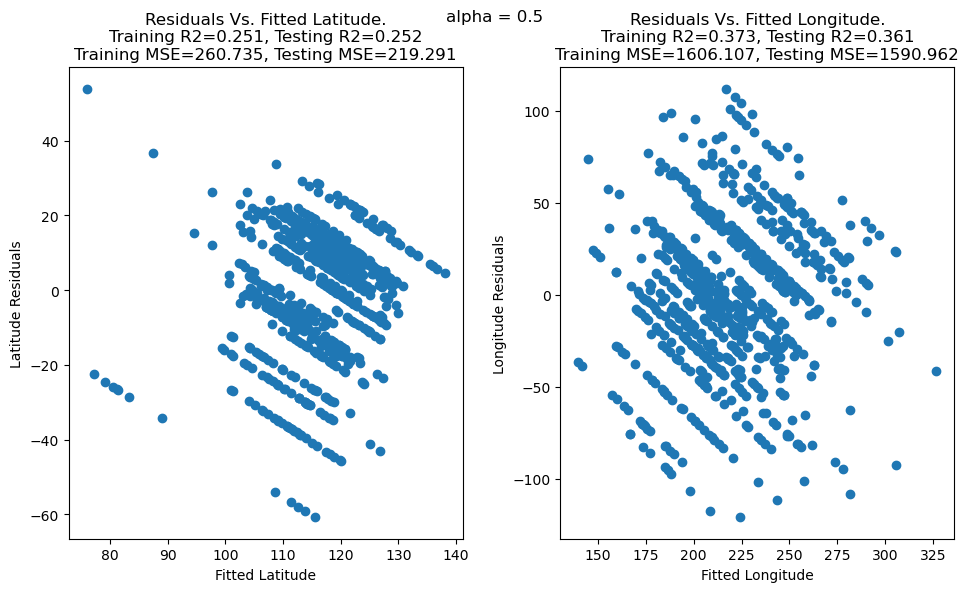

In [33]:
if perform_computation:
    alpha = 0.5
    train_and_plot(lambda *args, **kwargs: glmnet_elastic(*args, **kwargs, alpha=alpha))
    _ = plt.gcf().suptitle(f'alpha = {alpha}')

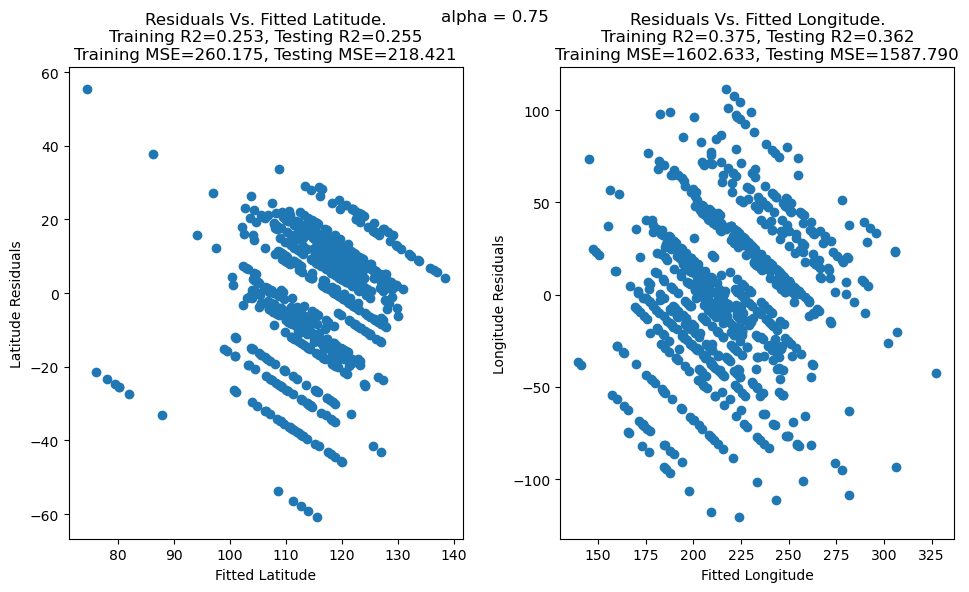

In [34]:
if perform_computation:
    alpha = 0.75
    train_and_plot(lambda *args, **kwargs: glmnet_elastic(*args, **kwargs, alpha=alpha))
    _ = plt.gcf().suptitle(f'alpha = {alpha}')

### Analysis

In [35]:
if perform_computation:
    _, alpha1_model = glmnet_elastic(X_train_val, lat_train_val, X_train_val, alpha=0.25)
    _, alpha2_model = glmnet_elastic(X_train_val, lat_train_val, X_train_val, alpha=0.5)
    _, alpha3_model = glmnet_elastic(X_train_val, lat_train_val, X_train_val, alpha=0.75)

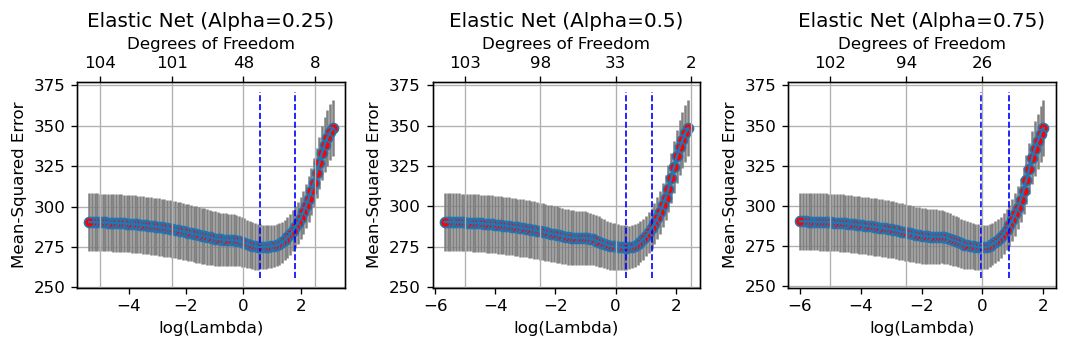

In [36]:
if perform_computation:
    f = plt.figure(figsize=(9,3), dpi=120)
    f.add_subplot(1,3,1)
    cvglmnetPlot(alpha1_model)
    plt.gca().set_title(f'Elastic Net (Alpha=0.25)')
    f.add_subplot(1,3,2)
    cvglmnetPlot(alpha2_model)
    plt.gca().set_title(f'Elastic Net (Alpha=0.5)')
    f.add_subplot(1,3,3)
    cvglmnetPlot(alpha3_model)
    _ = plt.gca().set_title(f'Elastic Net (Alpha=0.75)')
    plt.tight_layout()

With an alpha of 0.25, a Total of 39 elastic-net coefficients were non-zero.
With an alpha of 0.50, a Total of 29 elastic-net coefficients were non-zero.
With an alpha of 0.75, a Total of 28 elastic-net coefficients were non-zero.


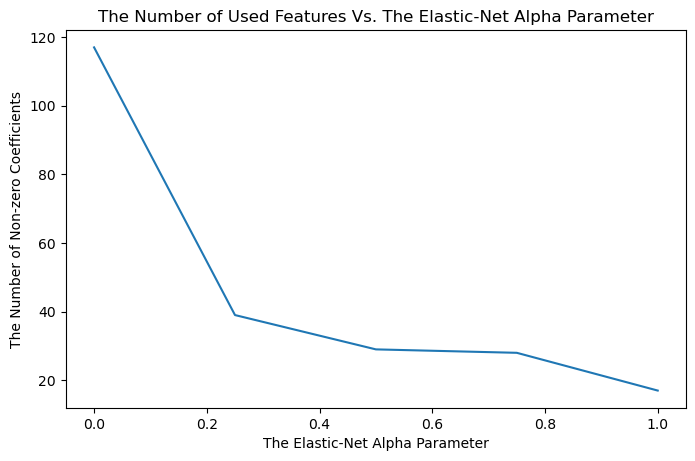

In [37]:
if perform_computation:
    alpha1_nz_coefs = np.sum(cvglmnetCoef(alpha1_model, s = 'lambda_min') != 0)
    alpha2_nz_coefs = np.sum(cvglmnetCoef(alpha2_model, s = 'lambda_min') != 0)
    alpha3_nz_coefs = np.sum(cvglmnetCoef(alpha3_model, s = 'lambda_min') != 0)

    print(f'With an alpha of 0.25, a Total of {alpha1_nz_coefs} elastic-net coefficients were non-zero.')
    print(f'With an alpha of 0.50, a Total of {alpha2_nz_coefs} elastic-net coefficients were non-zero.')
    print(f'With an alpha of 0.75, a Total of {alpha3_nz_coefs} elastic-net coefficients were non-zero.')

    fig,ax = plt.subplots(figsize=(8,5), dpi=100)
    ax.plot([0,0.25,0.5,0.75,1], [ridge_nz_coefs, alpha1_nz_coefs, alpha2_nz_coefs, alpha3_nz_coefs, lasso_nz_coefs])
    ax.set_xlabel('The Elastic-Net Alpha Parameter')
    ax.set_ylabel('The Number of Non-zero Coefficients')
    _ = ax.set_title('The Number of Used Features Vs. The Elastic-Net Alpha Parameter')

# 2. Problem 2

## 2.0 Data

### Description

The UCI Machine Learning dataset repository hosts a dataset giving whether a Taiwanese credit card user defaults against a variety of features at http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients. 

### Information Summary

* **Input/Output**: This data has 24 columns; the first 23 columns are the features, and the last column is an indicator variable telling whether the next month's payment was defaulted.

* **Missing Data**: There is no missing data.

* **Final Goal**: We want to **properly** fit a logistic regression model.

In [38]:
df = pd.read_csv('credit/credit.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [39]:
X_full = df.iloc[:,:-1].values
Y_full = df.iloc[:,-1].values
X_full.shape, Y_full.shape

((30000, 23), (30000,))

## 2.1 Outlier Detection

In [40]:
outlier_detector = 'LOF'

if outlier_detector == 'LOF':
    outlier_clf = LocalOutlierFactor(novelty=False)
elif outlier_detector == 'IF':
    outlier_clf = IsolationForest(warm_start=True, random_state=12345)
elif outlier_detector == 'EE':
    outlier_clf = EllipticEnvelope(random_state=12345)
else:
    outlier_clf = None

is_not_outlier = outlier_clf.fit_predict(X_full) if outlier_clf is not None else np.ones_like(lat_full)>0
X_useful = X_full[is_not_outlier==1,:]
Y_useful = Y_full[is_not_outlier==1]

X_useful.shape, Y_useful.shape

((23456, 23), (23456,))

## 2.2 Train-Validation-Test Split

In [41]:
train_val_indices, test_indices = train_test_split(np.arange(X_useful.shape[0]), test_size=0.2, random_state=12345)

X_train_val = X_useful[train_val_indices, :]
Y_train_val = Y_useful[train_val_indices]

X_test = X_useful[test_indices, :]
Y_test = Y_useful[test_indices]

## 2.3 Elastic Net Logistic Regression

# <span style="color:blue">Task 9</span>

Write a function `glmnet_logistic_elastic` that fits an elastic-net logistic regression model from the glmnet library, and takes the following arguments as input:

1. `X_train`: A numpy array of the shape `(N,d)` where `N` is the number of training data points, and `d` is the data dimension. Do not assume anything about `N` or `d` other than being a positive integer.
2. `Y_train`: A numpy array of the shape `(N,)` where `N` is the number of training data points.
3. `X_test`: A numpy array of the shape `(N_test,d)` where `N_test` is the number of testing data points, and `d` is the data dimension.
4. `alpha`: The elastic-net regularization parameter $\alpha$.

Your model should train on the training features and labels, and then predict on the test data. Your model should return the following two items:

1. `fitted_Y_test`: The predicted values on the test data as a numpy array with a shape of `(N_test,)` where `N_test` is the number of testing data points. These values should indicate the prediction classes for test data, and should be either 0 or 1.

2. `glmnet_model`: The glmnet library's returned model stored as a python dictionary.

**Important Notes**:
1. **Do not** play with the default options unless you're instructed to.
2. You may find this glmnet documentation helpful: https://github.com/bbalasub1/glmnet_python/blob/master/test/glmnet_examples.ipynb
  * You may find it useful to read about the logistic family in the last sections.
3. You **should** perform **cross-validation** for this task.
4. Use **10-folds** for cross-validation.
5. Ask glmnet to search over **100** different values of the regularization coefficient.
6. Use the **Misclassification Error** as a metric for cross-validation.
7. For **prediction**, use the **regularization coefficient** that produces the **minimum cross-validation misclassification**.
7. You may need to choose the proper `family` variable when you're training the model.
8. You may need to choose the proper `ptype` variable when you're predicting on the test data.

In [42]:
def glmnet_logistic_elastic(X_train, Y_train, X_test=None, alpha=1):
    
    if X_test is None:
        X_test = X_train.copy().astype(np.float64)
    # Creating Scratch Variables For glmnet consumption
    X_train = X_train.copy().astype(np.float64)
    Y_train = Y_train.copy().astype(np.float64)
    
    # your code here
    glmnet_model = cvglmnet(x = X_train, y = Y_train, ptype = 'class', nfolds = 10, family = 'binomial', alpha=alpha, nlambda = 100)
    fitted_Y_test = cvglmnetPredict(glmnet_model, newx = X_test, s='lambda_min', ptype='class').reshape(-1)
    
    assert fitted_Y_test.shape == (X_test.shape[0],), 'fitted_Y should not be two dimensional (hint: reshaping may be helpful)'
    assert isinstance(glmnet_model, dict)
    return fitted_Y_test, glmnet_model

In [43]:
some_X = (np.arange(350).reshape(70,5) ** 13) % 20
some_Y = np.sum(some_X, axis=1)%2
some_pred, some_model = glmnet_logistic_elastic(some_X, some_Y, alpha=0.3)
assert np.array_equal(some_pred.round(3)[:5], np.array([0., 0., 0., 1., 0.]))

# Checking against the pre-computed test database
test_results = test_case_checker(lambda *args,**kwargs: glmnet_logistic_elastic(*args,**kwargs)[0], task_id=9)
assert test_results['passed'], test_results['message']

### Analysis

In [44]:
if perform_computation:
    _, ridge_model = glmnet_logistic_elastic(X_train_val, Y_train_val, X_train_val, alpha=0.00)
    _, alpha1_model = glmnet_logistic_elastic(X_train_val, Y_train_val, X_train_val, alpha=0.25)
    _, alpha2_model = glmnet_logistic_elastic(X_train_val, Y_train_val, X_train_val, alpha=0.50)
    _, alpha3_model = glmnet_logistic_elastic(X_train_val, Y_train_val, X_train_val, alpha=0.75)
    _, lasso_model = glmnet_logistic_elastic(X_train_val, Y_train_val, X_train_val, alpha=1.00)

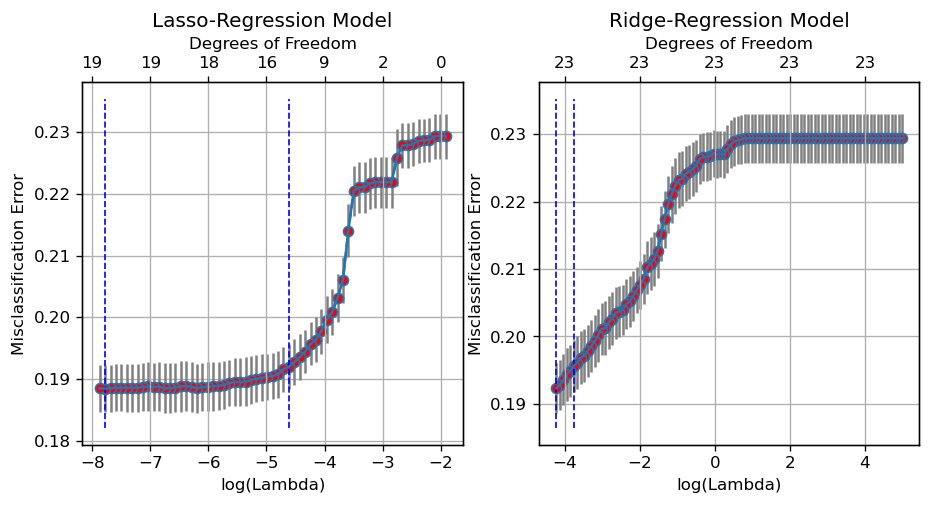

In [45]:
if perform_computation:
    f = plt.figure(figsize=(9,4), dpi=120)
    f.add_subplot(1,2,1)
    cvglmnetPlot(lasso_model)
    plt.gca().set_title('Lasso-Regression Model')
    f.add_subplot(1,2,2)
    cvglmnetPlot(ridge_model)
    _ = plt.gca().set_title('Ridge-Regression Model')

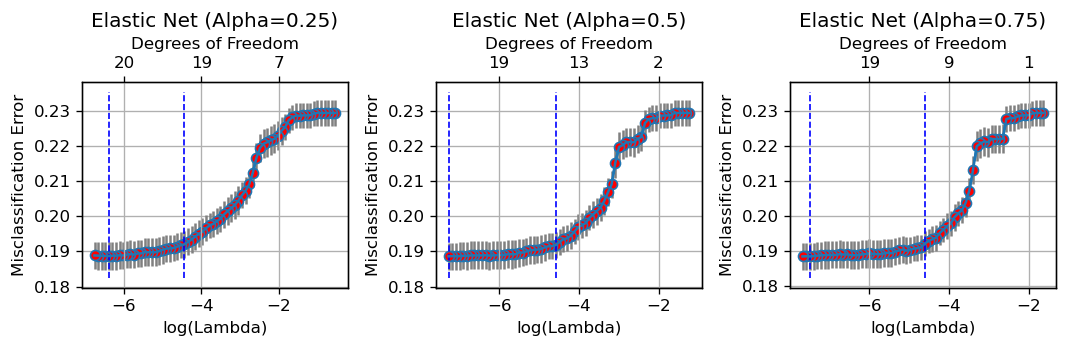

In [46]:
if perform_computation:
    f = plt.figure(figsize=(9,3), dpi=120)
    f.add_subplot(1,3,1)
    cvglmnetPlot(alpha1_model)
    plt.gca().set_title(f'Elastic Net (Alpha=0.25)')
    f.add_subplot(1,3,2)
    cvglmnetPlot(alpha2_model)
    plt.gca().set_title(f'Elastic Net (Alpha=0.5)')
    f.add_subplot(1,3,3)
    cvglmnetPlot(alpha3_model)
    _ = plt.gca().set_title(f'Elastic Net (Alpha=0.75)')
    plt.tight_layout()

A Total of 24 Ridge-Regression coefficients were non-zero.
With an alpha of 0.25, a Total of 21 elastic-net coefficients were non-zero.
With an alpha of 0.50, a Total of 20 elastic-net coefficients were non-zero.
With an alpha of 0.75, a Total of 20 elastic-net coefficients were non-zero.
A Total of 20 Lasso-Regression coefficients were non-zero.


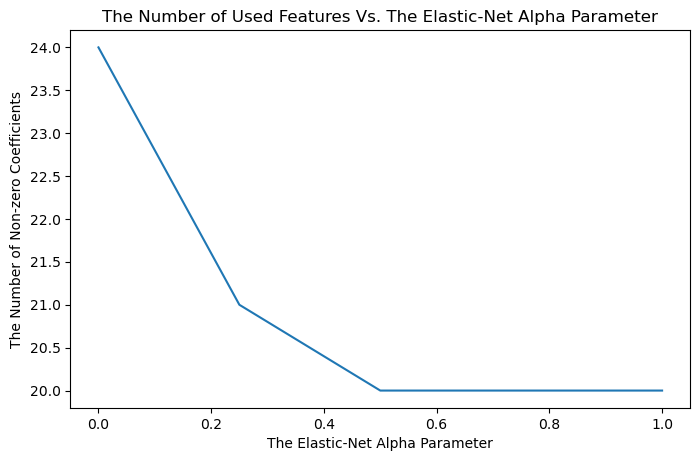

In [47]:
if perform_computation:
    lasso_nz_coefs = np.sum(cvglmnetCoef(lasso_model, s = 'lambda_min') != 0)
    ridge_nz_coefs = np.sum(cvglmnetCoef(ridge_model, s = 'lambda_min') != 0)
    alpha1_nz_coefs = np.sum(cvglmnetCoef(alpha1_model, s = 'lambda_min') != 0)
    alpha2_nz_coefs = np.sum(cvglmnetCoef(alpha2_model, s = 'lambda_min') != 0)
    alpha3_nz_coefs = np.sum(cvglmnetCoef(alpha3_model, s = 'lambda_min') != 0)

    print(f'A Total of {ridge_nz_coefs} Ridge-Regression coefficients were non-zero.')
    print(f'With an alpha of 0.25, a Total of {alpha1_nz_coefs} elastic-net coefficients were non-zero.')
    print(f'With an alpha of 0.50, a Total of {alpha2_nz_coefs} elastic-net coefficients were non-zero.')
    print(f'With an alpha of 0.75, a Total of {alpha3_nz_coefs} elastic-net coefficients were non-zero.')
    print(f'A Total of {lasso_nz_coefs} Lasso-Regression coefficients were non-zero.')

    fig,ax = plt.subplots(figsize=(8,5), dpi=100)
    ax.plot([0,0.25,0.5,0.75,1], [ridge_nz_coefs, alpha1_nz_coefs, alpha2_nz_coefs, alpha3_nz_coefs, lasso_nz_coefs])
    ax.set_xlabel('The Elastic-Net Alpha Parameter')
    ax.set_ylabel('The Number of Non-zero Coefficients')
    _ = ax.set_title('The Number of Used Features Vs. The Elastic-Net Alpha Parameter')